# Elite Overproduction: Testing Turchin's Hypothesis

Testing whether administrative complexity correlates with intra-elite conflict using CrisisDB + Seshat.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path

Path("figures").mkdir(exist_ok=True)
sns.set_style("whitegrid")

In [2]:
crisis = pd.read_csv("power_transitions.csv", sep="|")
equinox = pd.ExcelFile("../data/Equinox_on_GitHub_June9_2022.xlsx")
polities = pd.read_excel(equinox, sheet_name="Polities")
seshat = pd.read_excel(equinox, sheet_name="Equinox2020_CanonDat")

print(f"CrisisDB: {len(crisis):,} transitions, {crisis['polity_new_ID'].nunique()} polities")
print(f"Seshat: {len(polities)} polities")

CrisisDB: 3,447 transitions, 264 polities
Seshat: 444 polities


## Data Prep

In [3]:
# Binary coding: P or IP = present
mech_cols = ['intra_elite', 'predecessor_assassination', 'military_revolt']
for col in mech_cols:
    crisis[f"{col}_b"] = crisis[col].isin(['P', 'IP']).astype(int)

# Aggregate by polity
crisis['name_norm'] = crisis['polity_name'].str.lower().str.strip()
crisis_agg = crisis.groupby('name_norm').agg(
    n=('transition_year', 'count'),
    n_intra=('intra_elite_b', 'sum'),
    n_assn=('predecessor_assassination_b', 'sum'),
    n_mil=('military_revolt_b', 'sum'),
).reset_index()

crisis_agg['intra_rate'] = crisis_agg['n_intra'] / crisis_agg['n']
crisis_agg['assn_rate'] = crisis_agg['n_assn'] / crisis_agg['n']
crisis_agg['mil_rate'] = crisis_agg['n_mil'] / crisis_agg['n']

In [4]:
# Extract hierarchical complexity
hier = seshat[seshat['Subsection'] == 'Hierarchical Complexity'].copy()
hier['value'] = pd.to_numeric(hier['Value.From'], errors='coerce')
complexity = hier.pivot_table(index='Polity', columns='Variable', values='value', aggfunc='mean')

# Merge
polities['name_norm'] = polities['PolName'].str.lower().str.strip()
complexity_named = complexity.reset_index().merge(polities[['PolID', 'name_norm']], 
                                                   left_on='Polity', right_on='PolID', how='left')
merged = crisis_agg.merge(complexity_named, on='name_norm', how='inner')

# Filter: min 5 transitions, has admin data
df = merged[(merged['n'] >= 5) & (merged['Administrative levels'].notna())].drop_duplicates('name_norm')
print(f"Analysis sample: {len(df)} polities")

Analysis sample: 87 polities


## Hypothesis Test

**H1**: Admin complexity → intra-elite conflict (positive correlation)

In [5]:
x = df['Administrative levels'].values
y = df['intra_rate'].values

r, p = stats.pearsonr(x, y)
rho, p_s = stats.spearmanr(x, y)

print(f"Pearson:  r = {r:.3f}, p = {p/2:.4f} (one-tailed)")
print(f"Spearman: ρ = {rho:.3f}, p = {p_s/2:.4f}")
print(f"n = {len(x)}")

Pearson:  r = 0.362, p = 0.0003 (one-tailed)
Spearman: ρ = 0.395, p = 0.0001
n = 87


In [6]:
X = sm.add_constant(df['Administrative levels'])
model = sm.OLS(df['intra_rate'], X).fit()

beta = model.params['Administrative levels']
ci = model.conf_int().loc['Administrative levels']
print(f"β = {beta:.3f} [95% CI: {ci[0]:.3f}, {ci[1]:.3f}]")
print(f"Each admin level → +{beta*100:.1f} pp intra-elite conflict")
print(f"R² = {model.rsquared:.3f}")

β = 0.056 [95% CI: 0.025, 0.087]
Each admin level → +5.6 pp intra-elite conflict
R² = 0.131


## Visualizations

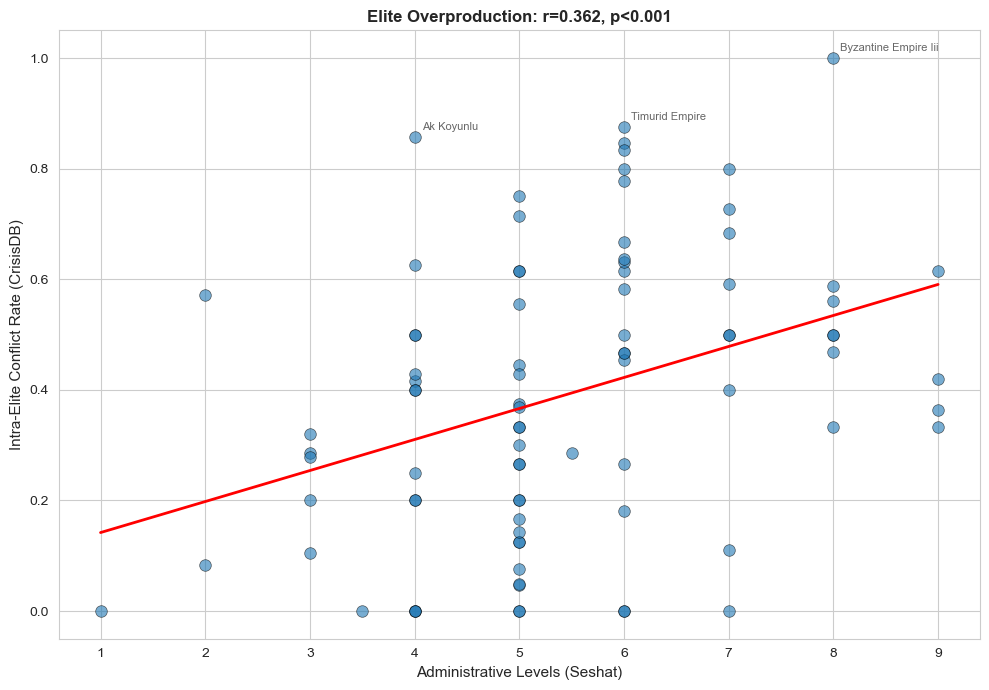

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(x, y, alpha=0.6, s=70, edgecolor='black', linewidth=0.5)

# Regression line
x_line = np.linspace(x.min(), x.max(), 100)
ax.plot(x_line, model.params['const'] + beta * x_line, 'r-', linewidth=2)

# Label notable polities
notable = df.nlargest(3, 'intra_rate')[['name_norm', 'Administrative levels', 'intra_rate']]
for _, row in notable.iterrows():
    ax.annotate(row['name_norm'].title(), (row['Administrative levels'], row['intra_rate']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax.set_xlabel('Administrative Levels (Seshat)', fontsize=11)
ax.set_ylabel('Intra-Elite Conflict Rate (CrisisDB)', fontsize=11)
ax.set_title(f'Elite Overproduction: r={r:.3f}, p<0.001', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/02_elite_overproduction.png', dpi=150)
plt.show()

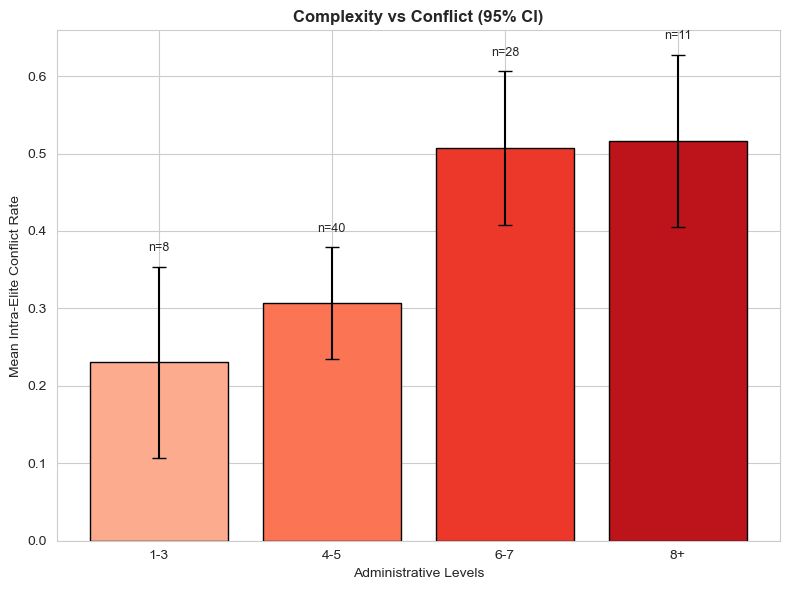

In [8]:
df['admin_bin'] = pd.cut(df['Administrative levels'], bins=[0, 3, 5, 7, 10], labels=['1-3', '4-5', '6-7', '8+'])
binned = df.groupby('admin_bin', observed=True)['intra_rate'].agg(['mean', 'std', 'count'])
binned['se'] = binned['std'] / np.sqrt(binned['count'])

fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(binned)))
ax.bar(range(len(binned)), binned['mean'], yerr=binned['se']*1.96, capsize=5, 
       color=colors, edgecolor='black')
ax.set_xticks(range(len(binned)))
ax.set_xticklabels(binned.index)
ax.set_xlabel('Administrative Levels')
ax.set_ylabel('Mean Intra-Elite Conflict Rate')
ax.set_title('Complexity vs Conflict (95% CI)', fontweight='bold')

for i, (_, row) in enumerate(binned.iterrows()):
    ax.text(i, row['mean'] + row['se']*1.96 + 0.02, f'n={int(row["count"])}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/02_elite_binned.png', dpi=150)
plt.show()

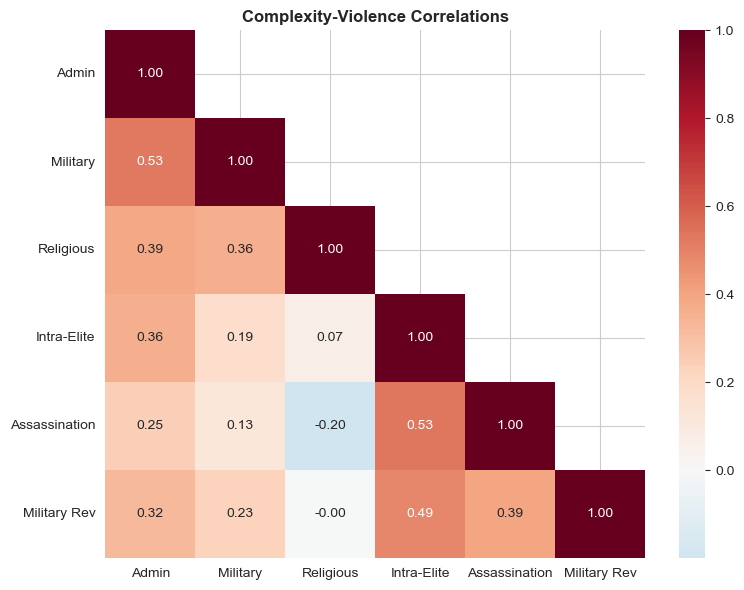

In [9]:
vars_to_corr = ['Administrative levels', 'Military levels', 'Religious levels', 
                'intra_rate', 'assn_rate', 'mil_rate']
corr = df[vars_to_corr].corr()

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=ax,
            xticklabels=['Admin', 'Military', 'Religious', 'Intra-Elite', 'Assassination', 'Military Rev'],
            yticklabels=['Admin', 'Military', 'Religious', 'Intra-Elite', 'Assassination', 'Military Rev'])
ax.set_title('Complexity-Violence Correlations', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/02_corr_matrix.png', dpi=150)
plt.show()

## Notable Cases

In [10]:
print("Highest intra-elite conflict (complex polities):")
print(df[df['Administrative levels'] >= 5].nlargest(5, 'intra_rate')[['name_norm', 'Administrative levels', 'intra_rate', 'n']].to_string(index=False))

print("\nLowest intra-elite conflict (complex polities):")
print(df[df['Administrative levels'] >= 5].nsmallest(5, 'intra_rate')[['name_norm', 'Administrative levels', 'intra_rate', 'n']].to_string(index=False))

Highest intra-elite conflict (complex polities):
                   name_norm  Administrative levels  intra_rate  n
        byzantine empire iii                    8.0    1.000000 10
              timurid empire                    6.0    0.875000  8
           achaemenid empire                    6.0    0.846154 13
          kamakura shogunate                    6.0    0.833333 12
egypt - mamluk sultanate iii                    7.0    0.800000 10

Lowest intra-elite conflict (complex polities):
                  name_norm  Administrative levels  intra_rate  n
               aztec empire                    6.0         0.0  7
egypt - classic old kingdom                    7.0         0.0 20
               rattanakosin                    6.0         0.0  5
      republic of venice iv                    5.0         0.0 23
          satavahana empire                    5.0         0.0 13


## Summary

**Result**: Administrative complexity positively correlates with intra-elite conflict.

| Metric | Value |
|--------|-------|
| Pearson r | 0.362 |
| p-value | <0.001 |
| Effect | +5.6 pp per admin level |
| R² | 0.131 |

Consistent with Turchin's elite overproduction theory: more hierarchy creates more competition for elite positions, manifesting as intra-elite conflict during power transitions.

**Limitations**: Correlation ≠ causation. Admin levels proxies elite production, doesn't measure it directly.

---

**Next**: [03_violence_contagion.ipynb](03_violence_contagion.ipynb) — Modeling violence dynamics with ML